# Recyclable Waste Classification

This notebook was created to serve as a supplement to [Recyclable and Household Waste Classification Code](https://www.kaggle.com/code/alistairking/recyclable-and-household-waste-classification-code), which implements and trains a CNN using PyTorch. In this notebook, we follow a similar process using [JAX](https://jax.readthedocs.io/en/latest/) and [FLAX](https://flax.readthedocs.io/en/latest/).

### Importing Relevant Libraries

In [19]:
import os
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from PIL import Image
import matplotlib.pyplot as plt
import random
import jax
import optax
from flax.training.train_state import TrainState
from jax import tree_util
from functools import partial
np.bool = np.bool_

### Loading Data
In this section, we define a `WasteDataset` class which directly interfaces with the dataset file structure. We also define `create_batches`, which is a function to batch the dataset using `jax.numpy`, and `transform_fn`, which normalizes an image.

In [3]:
# Define the dataset class (modified to include a split parameter)
class WasteDataset:
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)
                
                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]
                
                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        
        return image, label

In [4]:
# Create batches using JAX
def create_batches(dataset, batch_size, key):
    num_samples = len(dataset)
    indices = jax.random.permutation(key, jnp.arange(num_samples))
    batches = []
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_indices = indices[start:end]
        batch = [dataset[int(index)] for index in batch_indices]
        
        # Resize images to a consistent shape
        images, labels = zip(*batch)
        images = [jax.image.resize(image, (224, 224, 3), method='bilinear') for image in images]
        
        images = jnp.stack(images)
        labels = jnp.array(labels)
        
        batches.append((images, labels))
    
    return batches

def normalize(image, mean, std):
    return (image - mean) / std

def transform(image, size, mean, std):
    # Convert the PIL Image to a JAX array
    jax_image = jnp.array(image, dtype=jnp.float32)
    
    # Resize the image
    resized_image = jax.image.resize(jax_image, size, method='bilinear')
    
    # Scale the pixel values to the range [0, 1]
    scaled_image = resized_image / 255.0
    
    # Normalize the image
    normalized_image = normalize(scaled_image, jnp.array(mean), jnp.array(std))
    
    return normalized_image

transform_fn = partial(transform, size=(224, 224, 3), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

### Defining Hyperparameters + Dataloaders
In this module, we define hyperparameters such as `batch_size`, `num_epochs`, and `learning_rate`. We also utilize the classes and functions defined in the previous section to create `train_batches`, `val_batches`, and `test_batches`.

In [5]:
root_dir= 'recyclable-and-household-waste-classification/images/images'
key = jax.random.PRNGKey(0)
batch_size = 32
num_epochs = 10
learning_rate = 1e-3

In [6]:
train_dataset = WasteDataset(root_dir, split='train', transform=transform_fn)
val_dataset = WasteDataset(root_dir, split='val', transform=transform_fn)
test_dataset = WasteDataset(root_dir, split='test', transform=transform_fn)

train_batches = create_batches(train_dataset, batch_size, key)
val_batches = create_batches(val_dataset, batch_size, key)
test_batches = create_batches(test_dataset, batch_size, key)

### Defining Model Architecture
We opt for a simple CNN with 2 layers each structured as: `nn.Conv() --> nn.Dropout() --> nn.relu() --> nn.max_pool`. This is followed by a set of `nn.Dense` layers.

In [7]:
class CNN(nn.Module):
    num_classes: int

    @nn.compact
    def __call__(self, x, training: bool):
        x = nn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)

        return x

### Defining Loss, Accuracy, Training, and Eval Functions
In this section, we define `cross_entropy_loss()`, `accuracy()`, `train_step()`, and `eval_step()`.

In [8]:
# Define the loss function
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=logits.shape[-1])
    return -jnp.mean(jnp.sum(one_hot_labels * nn.log_softmax(logits), axis=-1))

# Define the accuracy metric
def accuracy(logits, labels):
    predicted_labels = jnp.argmax(logits, axis=-1)
    return jnp.mean(predicted_labels == labels)

# Define the train step with L2 regularization
@jax.jit
def train_step(state, batch, l2_reg=1e-3):
    dropout_train_key = jax.random.fold_in(key=state.key, data=state.step)
    images, labels = batch

    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params}, 
            images, 
            training=True, 
            rngs={'dropout': dropout_train_key}
        )
        loss = cross_entropy_loss(logits, labels)
        
        # Add L2 regularization term
        l2_loss = sum(jnp.sum(jnp.square(p)) for p in tree_util.tree_leaves(params))
        loss = loss + l2_reg * l2_loss
        
        return loss, (logits)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits)), grads = grad_fn(state.params)
    max_grad_norm = 1.0  # Adjust the maximum gradient norm as needed
    grads = jax.tree_map(lambda g: jnp.clip(g, -max_grad_norm, max_grad_norm), grads)
    state = state.apply_gradients(grads=grads)
    metrics = {'loss': loss, 'accuracy': accuracy(logits, labels)}
    return state, metrics

# Define the eval step
@jax.jit
def eval_step(state, batch):
    images, labels = batch
    logits = state.apply_fn({'params': state.params}, images, training=False)
    return {'loss': cross_entropy_loss(logits, labels), 'accuracy': accuracy(logits, labels)}

### Initializing The Model And Optimizer
Here, we intialize the model and use `optax.adam()` as our optimizer.

In [9]:
# Initialize the model and optimizer
model = CNN(num_classes=len(train_dataset))
rng = jax.random.PRNGKey(0)
variables = model.init(rng, jnp.ones((1, 224, 224, 3)), training=False)
params = variables['params']
tx = optax.adam(learning_rate)

dropout_key = jax.random.PRNGKey(1)
class TS(TrainState):
    key: jax.Array

state = TS.create(apply_fn=model.apply, params=params, key=dropout_key, tx=tx)

### Training The Model
This section contains the code to train the model and visualizes the loss and accuracy.

In [10]:
# Initialize lists to store the metrics for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Execute on the training set
    train_metrics = []
    for batch in train_batches:
        state, metrics = train_step(state, batch)
        train_metrics.append(metrics)
 
    train_metrics = {k: jnp.mean(jnp.array([metrics[k] for metrics in train_metrics])) for k in train_metrics[0]}
    train_losses.append(train_metrics['loss'])
    train_accuracies.append(train_metrics['accuracy'])
    
    # Evaluate on the validation set
    val_metrics = []
    for batch in val_batches:
        metrics = eval_step(state, batch)
        val_metrics.append(metrics)

    val_metrics = {k: jnp.mean(jnp.array([metrics[k] for metrics in val_metrics])) for k in val_metrics[0]}
    val_losses.append(val_metrics['loss'])
    val_accuracies.append(val_metrics['accuracy'])    
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {metrics['loss']:.4f}, Train Acc: {metrics['accuracy']:.4f}, Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

C:\Users\Rakib\AppData\Local\Temp\ipykernel_9812\1945674727.py:35: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  grads = jax.tree_map(lambda g: jnp.clip(g, -max_grad_norm, max_grad_norm), grads)
C:\Users\Rakib\AppData\Local\Temp\ipykernel_9812\1945674727.py:35: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  grads = jax.tree_map(lambda g: jnp.clip(g, -max_grad_norm, max_grad_norm), grads)


Epoch 1/10 - Train Loss: 4.7801, Train Acc: 0.4167, Val Loss: 5.1138, Val Acc: 0.4419
Epoch 2/10 - Train Loss: 3.8665, Train Acc: 0.6250, Val Loss: 4.0656, Val Acc: 0.6556
Epoch 3/10 - Train Loss: 2.7950, Train Acc: 0.6667, Val Loss: 2.9209, Val Acc: 0.7262
Epoch 4/10 - Train Loss: 2.8385, Train Acc: 0.6250, Val Loss: 3.0020, Val Acc: 0.7430
Epoch 5/10 - Train Loss: 2.4550, Train Acc: 0.6667, Val Loss: 2.7126, Val Acc: 0.7561
Epoch 6/10 - Train Loss: 2.0893, Train Acc: 0.8333, Val Loss: 2.6043, Val Acc: 0.7612
Epoch 7/10 - Train Loss: 2.2867, Train Acc: 0.6250, Val Loss: 2.5315, Val Acc: 0.7626
Epoch 8/10 - Train Loss: 2.5011, Train Acc: 0.6667, Val Loss: 2.8218, Val Acc: 0.7784
Epoch 9/10 - Train Loss: 2.5257, Train Acc: 0.7500, Val Loss: 2.4949, Val Acc: 0.7759
Epoch 10/10 - Train Loss: 2.4488, Train Acc: 0.7083, Val Loss: 2.9187, Val Acc: 0.7695


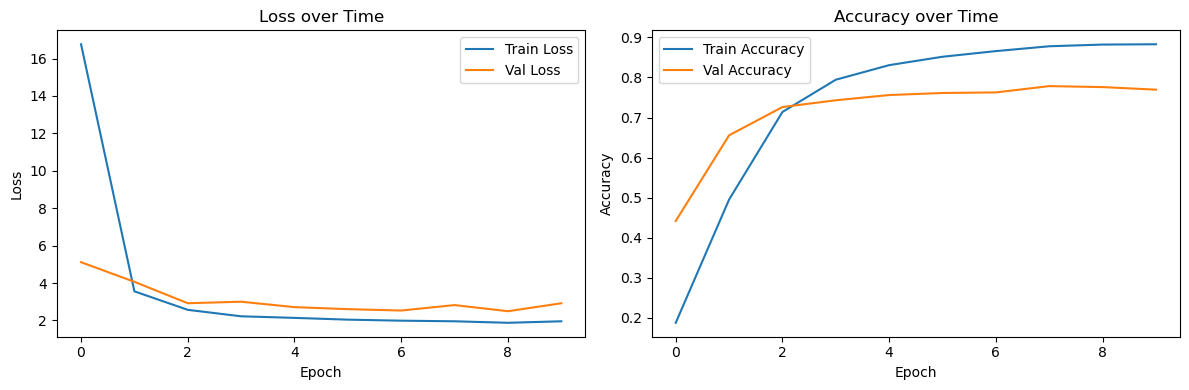

In [11]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss over time
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Time')
ax1.legend()

# Plot accuracy over time
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Time')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### Evaluating The Model On Test Dataset + Visualizing Predictions

In [12]:
# Evaluate on the test set
test_metrics = []
for batch in test_batches:
    metrics = eval_step(state, batch)
    test_metrics.append(metrics)

test_metrics = {k: jnp.mean(jnp.array([metrics[k] for metrics in test_metrics])) for k in test_metrics[0]}
print(f"Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")

Test Loss: 2.9457, Test Acc: 0.7438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


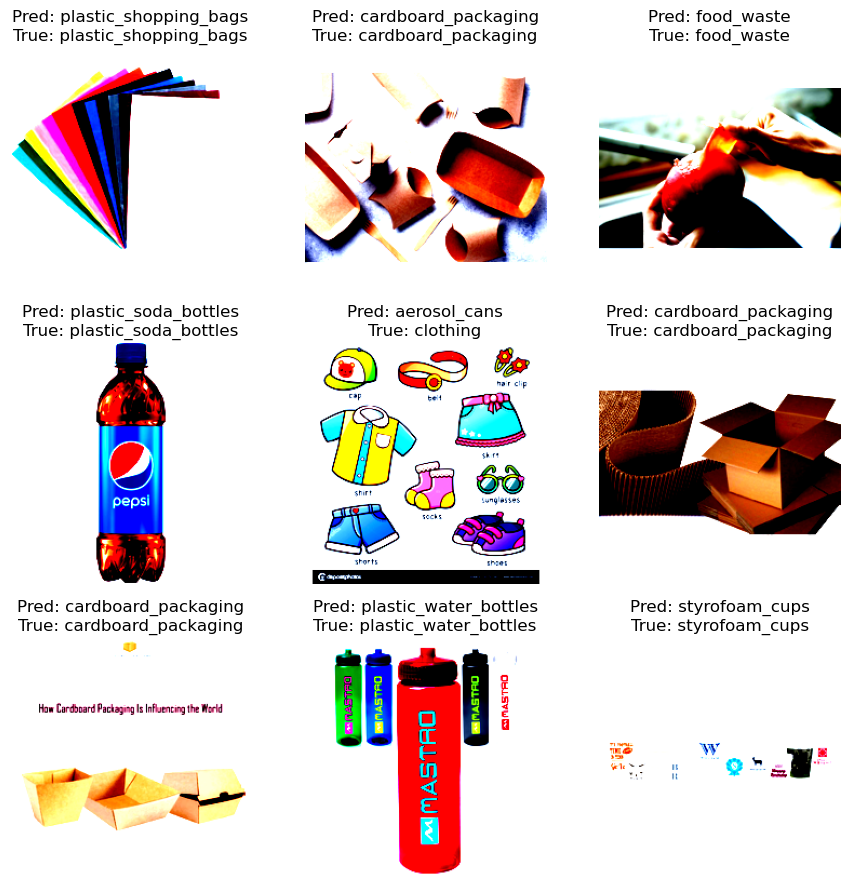

In [13]:
# Function to display 9 predictions from the model
def display_predictions(state, test_batches, class_names):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i >= len(test_batches):
            break
        
        batch = test_batches[i]
        x, y = batch
        
        # Make predictions
        logits = state.apply_fn({'params': state.params}, x, training=False)
        probs = jax.nn.softmax(logits, axis=-1)
        preds = np.argmax(probs, axis=-1)
        
        # Select a random image from the batch
        idx = np.random.choice(x.shape[0])
        image = x[idx]
        true_label = y[idx]
        pred_label = preds[idx]
        
        # Display the image and prediction
        ax.imshow(image)
        ax.set_title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 9 predictions from the model
class_names = [x for x in test_dataset.classes]
display_predictions(state, test_batches, class_names)

### Supplemental: Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
# Generate predictions for the test set
test_preds = []
test_labels = []

for batch in test_batches:
    x, y = batch
    logits = state.apply_fn({'params': state.params}, x, training=False)
    probs = jax.nn.softmax(logits, axis=-1)
    preds = np.argmax(probs, axis=-1)
    test_preds.extend(preds.tolist())
    test_labels.extend(y.tolist())

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

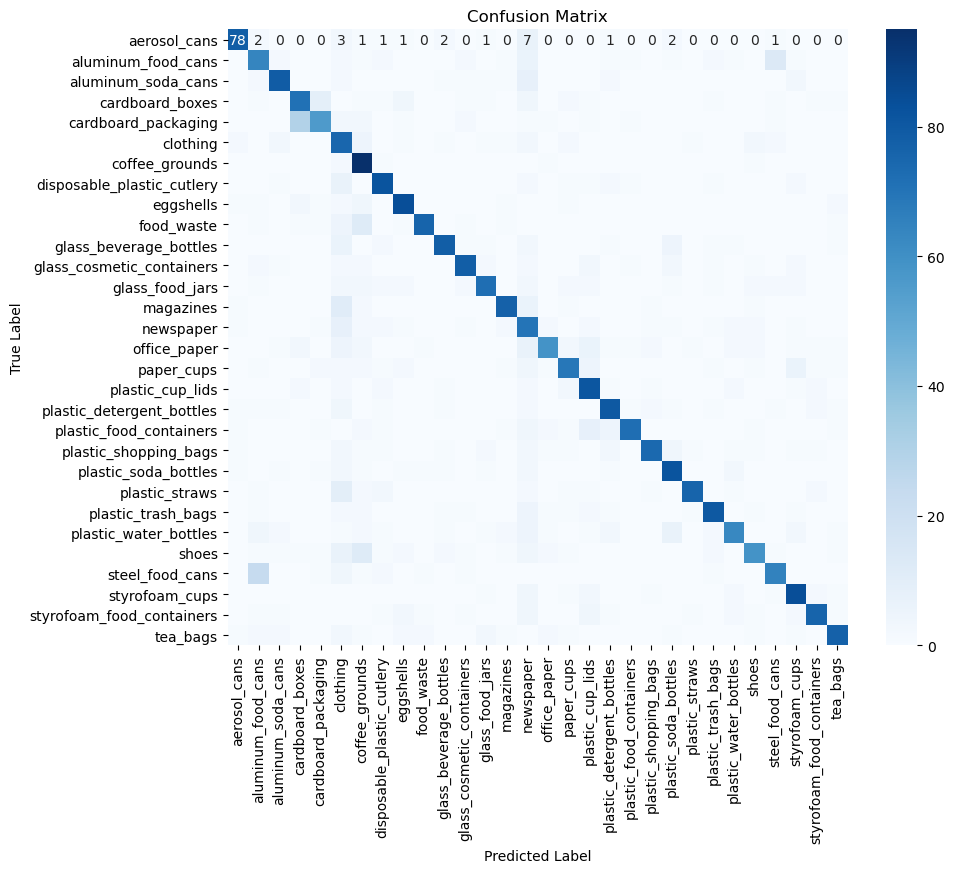

In [20]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()